# Text Analytics - Assignment 1

Submitted by: Arjun Varma, Nimish Amlathe, daniel Peng, Ann Li, Rachel Wang

# Part A

In [2]:
from pandas import Series, DataFrame
import pandas as pd
import nltk
import operator
import re,string
from patsy import dmatrices
%pylab inline
from nltk.corpus import stopwords
import re

Populating the interactive namespace from numpy and matplotlib


## A1. What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?

### (1) import file

In [7]:
train = pd.read_csv('Train_rev1.csv')
train[:5]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


### (2) tokenize the corpus

In [4]:
# Running only for 10,000 rows to reduce runtime
description  = train['FullDescription'][:1000]

corpus = description.str.cat(sep=' ')

corpus = corpus.decode('utf-8')

# Converting to lower case and making sure there are only alphabetic characters
corpus_words = nltk.word_tokenize(corpus.lower())

corpus_words = [word for word in corpus_words if word.isalpha()==True]

### (3) Calculate the frequencies of PoS

In [4]:
pos = nltk.pos_tag(corpus_words)

pos[:10]

[(u'engineering', 'NN'),
 (u'systems', 'NNS'),
 (u'analyst', 'NN'),
 (u'dorking', 'VBG'),
 (u'surrey', 'JJ'),
 (u'salary', 'JJ'),
 (u'our', 'PRP$'),
 (u'client', 'NN'),
 (u'is', 'VBZ'),
 (u'located', 'VBN')]

In [5]:
pos_freq = sorted(pos, key=lambda x: x[1],reverse=True)

df_pos = pd.DataFrame(pos_freq)

df_pos.columns = ['word','pos']

df_pos.groupby('pos').count().sort('word',ascending=False)[:5]

F:\Users\Arjun\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,word
pos,
NN,51790
JJ,23246
IN,23123
DT,17170
NNS,15271


## A2. Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law.

### (1) Calculate the frequencies of words

In [6]:
fdist = nltk.FreqDist(corpus_words)

In [7]:
c_sorted = sorted(fdist.items(), key=operator.itemgetter(1),reverse=True)

df = pd.DataFrame.from_records(c_sorted)
df.columns = ['word','freq']
df[:10]

,word,freq
0,and,8435
1,the,7121
2,to,6677
3,a,5812
4,of,4547
5,in,4229
6,for,3450
7,care,3033
8,with,2652
9,you,2469


### (2) Get rid of the punctuation marks and then rank 

In [8]:
mask = ~df['word'].isin(set(string.punctuation)) 

df = df[mask]

df['rank'] = df['freq'].rank(method='min',ascending=False)

In [9]:
df[:5][['word','freq','rank']]

,word,freq,rank
0,and,8435,1.0
1,the,7121,2.0
2,to,6677,3.0
3,a,5812,4.0
4,of,4547,5.0


### (3) Plot the most common 100 words in the corpus against the theoretical prediction of the law

F:\Users\Arjun\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


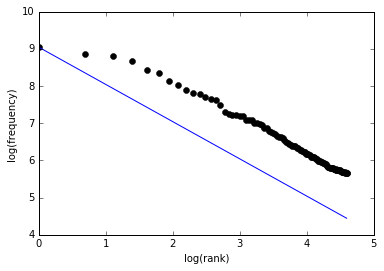

In [10]:
df_100 = df[:100]

# Theoretical value of Zipf's law
df_100['theoretical']= [df["freq"].max()/c for c in df_100['rank']]

import matplotlib.pyplot as plt

# Plotting actuals vs theoretical
fig = plt.figure()

ax = plt.plot([math.log(c) for c in df_100['rank'].values], [math.log(c) for c in df_100['freq']], 'ro',color='black')

ax2 = plt.plot([math.log(c) for c in df_100['rank'].values], [math.log(c) for c in df_100['theoretical']])

xlabel("log(rank)")
ylabel("log(frequency)")

This corpus does follow Zipf's law but the words with the higher frequencies do not follow the law as closely.

## A3. If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What is their frequency?

In [11]:
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer, WordNetLemmatizer

# Removing punctuations and stop words
corpus_words= [word for word in corpus_words if word not in set(string.punctuation)]
filtered_words_sw = [word for word in corpus_words if word not in stopwords.words('english')]

# Lemmatizing based on the POS
filtered_poi = nltk.pos_tag(filtered_words_sw)

wnl = WordNetLemmatizer()
wordnet_tag ={'NN':'n','JJ':'a','VB':'v','RB':'r'}
words_lem = []
for t in filtered_poi:
    try: words_lem.append(wnl.lemmatize(t[0],wordnet_tag[t[1][:2]]))
    except: words_lem.append(wnl.lemmatize(t[0]))

# Getting most common words
fdist_2 = nltk.FreqDist(words_lem)
fdist_2.most_common(10)

[(u'care', 3152),
 (u'work', 2169),
 (u'home', 2117),
 (u'experience', 1675),
 (u'nurse', 1505),
 (u'manager', 1276),
 (u'support', 1275),
 (u'within', 1040),
 (u'nursing', 941),
 (u'job', 941)]

## PART B 

  ## B1 Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? 

In [12]:
# Create a function that counts the frequency of each token in a document
def document_features(document):
    document_words = set(document)
    features = {}
    for word in corpus_words:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [13]:
# Find the cutoff salary
cutoff = np.percentile(train[['SalaryNormalized']], 75)
train['category'] = 'high'
train.ix[train.SalaryNormalized < cutoff, 'category'] = 'low'

train['token'] = ""
fullset = train[['FullDescription','token','category']][:1000]

# Calculate the document_features in each document
from __future__ import unicode_literals
for i in range(len(fullset)):
    words = re.sub(r'[^\w\s]','',fullset.FullDescription[i])
    token = nltk.word_tokenize(words.lower().decode('utf-8'))
    token = [w for w in token if w.isalpha()==True]
    feature = document_features(token)
    fullset.token[i] = feature

In [14]:
# Create the feature set and run the model
fullset['feature_sets'] = zip(fullset.token, fullset.category)
featuresets = fullset.feature_sets.tolist()
train_set, test_set = featuresets[:500], featuresets[500:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [17]:
print 'The accuracy is ', nltk.classify.accuracy(classifier, test_set)

The accuracy is  0.822


In [18]:
# Confusion matrix
test_mod = [x[0] for x in test_set]
predict = classifier.classify_many(test_mod)
actual = [x[1] for x in test_set]
cm = nltk.ConfusionMatrix(actual, predict)
print (cm.pretty_format(sort_by_count=True, show_percents=True))

     |             h |
     |      l      i |
     |      o      g |
     |      w      h |
-----+---------------+
 low | <80.6%>  8.6% |
high |   9.2%  <1.6%>|
-----+---------------+
(row = reference; col = test)



## B2 . Speculate before running the following analysis whether lemmatization would help improve the accuracy of classification. Now create a classification model after lemmatization. Did the classification accuracy increase relative to B1? Comment on your speculation versus the actual results you obtained. 

The lemmatization should improve the accuracy since there will be fewer tokens with less noise. With each token appearing in a document, the likelihood of the document being positive or negative should increase.

In [19]:
#Lemmatize words according to their pos in the corpus
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

for i in range(len(fullset)):
    words = re.sub(r'[^\w\s]','',fullset.FullDescription[i])
    token = nltk.word_tokenize(words.lower().decode('utf-8'))
    pos_i = nltk.pos_tag(token)
    wordnet_tag ={'NN':'n','JJ':'a','VB':'v','RB':'r'}
    resultList = []
    for t in pos_i:
        try: resultList.append(wnl.lemmatize(t[0],wordnet_tag[t[1][:2]]))
        except: resultList.append(wnl.lemmatize(t[0]))
    feature = document_features(resultList)
    fullset.token[i] = feature

In [20]:
#Run classification model
fullset['feature_sets'] = zip(fullset.token, fullset.category)
featuresets = fullset.feature_sets.tolist()
train_set, test_set = featuresets[:500], featuresets[500:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [21]:
print 'The accuracy: ', nltk.classify.accuracy(classifier, test_set)

The accuracy:  0.82


In [22]:
#confusion matrix
test_mod = [x[0] for x in test_set]
predict = classifier.classify_many(test_mod)
actual = [x[1] for x in test_set]
cm = nltk.ConfusionMatrix(actual, predict)
print (cm.pretty_format(sort_by_count=True, show_percents=True))

     |             h |
     |      l      i |
     |      o      g |
     |      w      h |
-----+---------------+
 low | <80.8%>  8.4% |
high |   9.6%  <1.2%>|
-----+---------------+
(row = reference; col = test)



After lemmatization, the accuracy actually went down slightly. Contrary to what we expected, lemmatization has minimal impact on the classification performance.

## B3. Now speculate whether stopwords removal from the original data would help increase the accuracy of the model. Take out the stopwords (but do not lemmatize), build a classification model and check the accuracy, and compare with that in B1 & B2.

Stop word removal should not affect the accuracy of our model in terms of predictive power. So, we think that they will not help in categorizing documents as they will occur in both classes randomly.

In [23]:
# Cleaning the data and removing stop words
from __future__ import unicode_literals
for i in range(len(fullset)):
    words = re.sub(r'[^\w\s]','',fullset.FullDescription[i])
    words = re.sub("[^a-zA-Z]", " ", words)
    words = words.lower().split()
    stops = set(stopwords.words("english")) 
    meaningful_words = [w for w in words if not w in stops] 
    clean_data = " ".join(meaningful_words)
    token = nltk.word_tokenize(clean_data.lower().decode('utf-8'))
    feature = document_features(token)
    fullset.token[i] = feature

In [26]:
# Creating the feature sets and running the classifier
fullset['feature_sets'] = zip(fullset.token, fullset.category)
featuresets = fullset.feature_sets.tolist()
train_set, test_set = featuresets[:500], featuresets[500:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

print 'The accuracy: ',nltk.classify.accuracy(classifier, test_set)

The accuracy:  0.82


In [25]:
print classifier.show_most_informative_features(10)

# Confusion matrix
test_set_mod = [x[0] for x in test_set]

predicted_categories_NaiveBayes = classifier.classify_many(test_set_mod)
actual_categories = [x[1] for x in test_set]

cm = nltk.ConfusionMatrix(actual_categories, predicted_categories_NaiveBayes)
print(cm.pretty_format(sort_by_count=True, show_percents=True))

Most Informative Features
      contains(regional) = True             high : low    =     20.9 : 1.0
  contains(relationship) = True             high : low    =     20.9 : 1.0
 contains(profitability) = True             high : low    =     20.9 : 1.0
 contains(presentations) = True             high : low    =     18.1 : 1.0
    contains(governance) = True             high : low    =     18.1 : 1.0
        contains(doctor) = True             high : low    =     16.3 : 1.0
contains(decommissioning) = True             high : low    =     16.3 : 1.0
         contains(units) = True             high : low    =     16.3 : 1.0
     contains(inservice) = True             high : low    =     16.3 : 1.0
    contains(beneficial) = True             high : low    =     16.3 : 1.0
None
     |             h |
     |      l      i |
     |      o      g |
     |      w      h |
-----+---------------+
 low | <80.6%>  8.6% |
high |   9.4%  <1.4%>|
-----+---------------+
(row = reference; col = test)



Stop word removal did not help with performance. The accuracy is similar to what we obtained from the earlier models.

## B4 .  Use the job descriptions without lemmatiztion and stopword removal. Add parts-of-speech bigrams to the bag-of-words, and run a new classification model. Does the accuracy increase over the results in B1?

In [27]:
# Add parts-of-speech bigrams to the bag-of-words
pos_bigram = list(nltk.bigrams(pos))
pattern = [('JJ', 'NN'),('JJ','NNS'),('NN','NNS')]
import copy
corpus_words_bi = copy.deepcopy(corpus_words)

for i in range(len(pos_bigram)):
    (a,b),(c,d) = pos_bigram[i]
    if (b,d) in pattern:
        corpus_words_bi.append(str(a)+' '+str(c))

In [28]:
# Define the function to create new features
def document_features_bigram(document):
    document_words = set(document)
    features = {}
    for wd in corpus_words_bi:
        features['contains({})'.format(wd)] = (wd in document_words)
    return features

In [29]:
# Find out the unigrams and bigrams in each job description that match the part-of-speech patterns we defined
for i in range(len(fullset)):
    words = re.sub(r'[^\w\s]','',fullset.FullDescription[i])
    tokens = nltk.word_tokenize(words.lower().decode('utf-8'))
    tokens = [w for w in tokens if w.isalpha()==True]
    tags = nltk.pos_tag(tokens)
    bigram = list(nltk.bigrams(tags))
    for n in range(len(bigram)):
        (a,b),(c,d) = bigram[n]
        if (b,d) in pattern:
            tokens.append(str(a)+' '+str(c))
    feature = document_features_bigram(tokens)
    fullset.token[i] = feature

In [30]:
# Run classification model
fullset['feature_sets'] = zip(fullset.token, fullset.category)
featuresets = fullset.feature_sets.tolist()
train_set, test_set = featuresets[:500], featuresets[500:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

print 'The accuracy: ',nltk.classify.accuracy(classifier, test_set)

The accuracy:  0.81


In [31]:
# Confusion matrix
test_mod = [x[0] for x in test_set]
predict = classifier.classify_many(test_mod)
actual = [x[1] for x in test_set]
cm = nltk.ConfusionMatrix(actual, predict)
print (cm.pretty_format(sort_by_count=True, show_percents=True))

     |             h |
     |      l      i |
     |      o      g |
     |      w      h |
-----+---------------+
 low | <79.6%>  9.6% |
high |   9.4%  <1.4%>|
-----+---------------+
(row = reference; col = test)



Despite adding bigrams which we speculated will have more predictive power than single words, the accuracy of the model did not improve when compared to B1.